
## Decision Trees and Information Gain
- Objective: Understand the construction and interpretation of decision trees for classification tasks. Explore how information gain and entropy guide the splitting process.

- Author: Xujia Qin
- Date: 2nd Jun 2025
- Dataset: Titanic dataset (seaborn.load_dataset("titanic"))

### Import libraries

In [34]:
# Import Libs

%pip install seaborn

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay, classification_report
)

import math  # For entropy and log2



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


### 1. Data Loading and Preprocessing

In [35]:
# Load the Titanic dataset from seaborn
df = sns.load_dataset("titanic")
df.head()

# Check for missing values
print("Missing values:\n", df.isnull().sum())

# Summary stats
print("\nSummary statistics:\n", df.describe())


Missing values:
 survived         0
pclass           0
sex              0
age            177
sibsp            0
parch            0
fare             0
embarked         2
class            0
who              0
adult_male       0
deck           688
embark_town      2
alive            0
alone            0
dtype: int64

Summary statistics:
          survived      pclass         age       sibsp       parch        fare
count  891.000000  891.000000  714.000000  891.000000  891.000000  891.000000
mean     0.383838    2.308642   29.699118    0.523008    0.381594   32.204208
std      0.486592    0.836071   14.526497    1.102743    0.806057   49.693429
min      0.000000    1.000000    0.420000    0.000000    0.000000    0.000000
25%      0.000000    2.000000   20.125000    0.000000    0.000000    7.910400
50%      0.000000    3.000000   28.000000    0.000000    0.000000   14.454200
75%      1.000000    3.000000   38.000000    1.000000    0.000000   31.000000
max      1.000000    3.000000   80.0000

In [36]:
# Data Cleaning and Feature Selection
# the relevant columns
df = df[['survived', 'pclass', 'sex', 'age', 'fare']]

# Check for missing values
df.isnull().sum()

survived      0
pclass        0
sex           0
age         177
fare          0
dtype: int64

In [37]:
# Drop rows with missing values (only 'age' has missing values here)
df = df.dropna()

# Encode 'sex' column
le = LabelEncoder()
df['sex'] = le.fit_transform(df['sex'])  # male=1, female=0

df.head()

,survived,pclass,sex,age,fare
0,0,3,1,22.0,7.2500
1,1,1,0,38.0,71.2833
2,1,3,0,26.0,7.9250
3,1,1,0,35.0,53.1000
4,0,3,1,35.0,8.0500


### 2. Modeling with Decision Tree

In [38]:
# Define features and target
X = df[['pclass', 'sex', 'age', 'fare']]
y = df['survived']

# Split into train and test sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Decision Tree with max depth of 3
clf = DecisionTreeClassifier(max_depth=3, random_state=42)
clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=42)

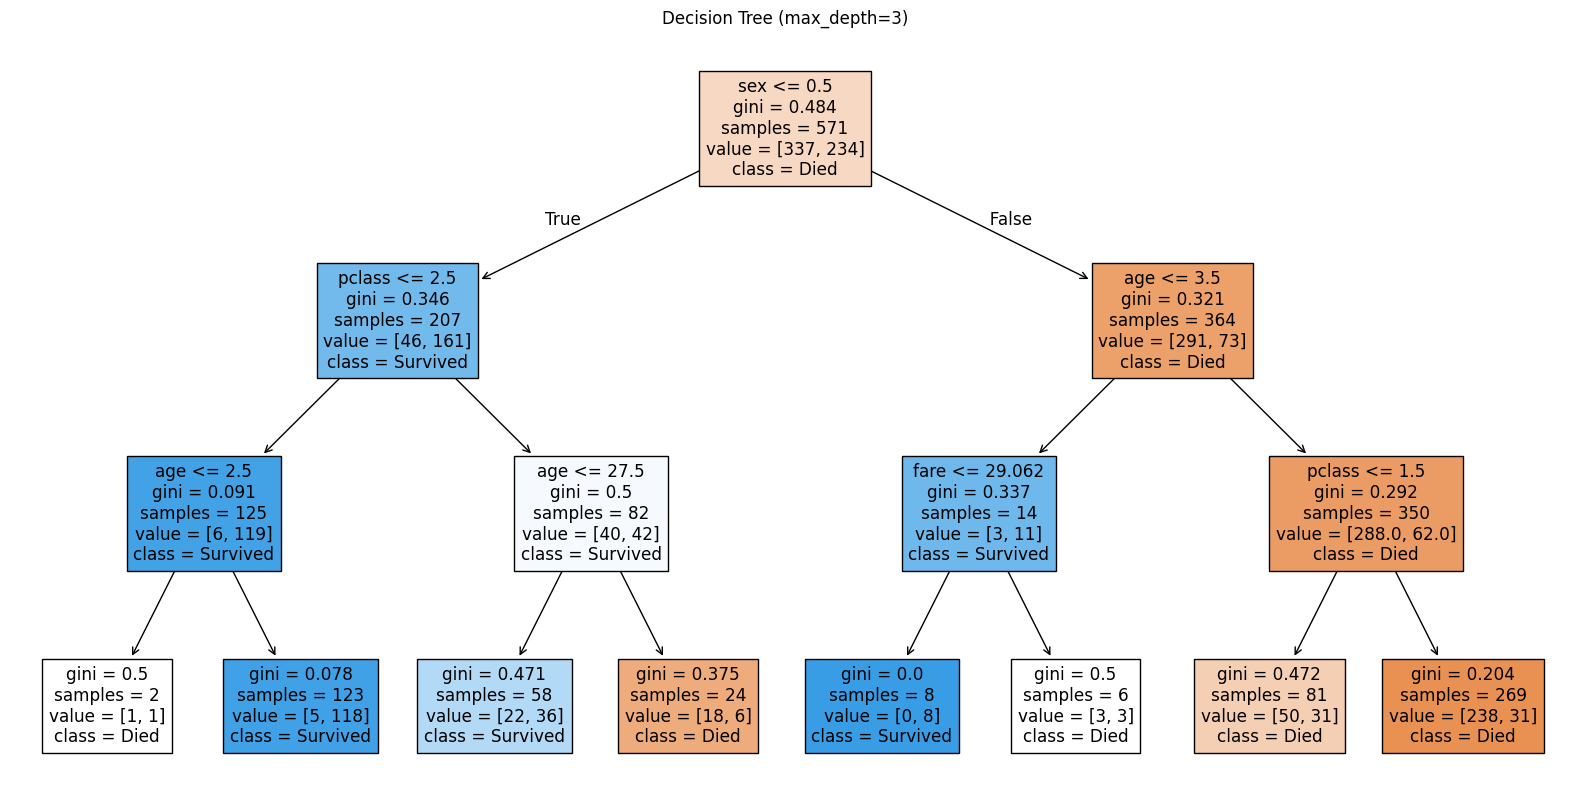

In [39]:
# Visualize the decision tree
plt.figure(figsize=(20, 10))
plot_tree(clf, feature_names=X.columns, class_names=['Died', 'Survived'], filled=True)
plt.title("Decision Tree (max_depth=3)")
plt.show()

#### Interpretation of First 3 Splits:
1. **First Split**: `sex <= 0.5` → This split is based on gender. Males (1) vs Females (0).
   - Suggests gender is a strong predictor of survival.

2. **Second Split (left branch)**: `pclass <= 2.5` for females.
   - Females in higher classes (1st or 2nd) had higher chances of survival.

3. **Third Split (right branch)**: `age <= 3.5` for males.
   - Suggests young boys had better survival odds among males.


### 3. Evaluation

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.83      0.80        87
           1       0.69      0.61      0.65        56

    accuracy                           0.74       143
   macro avg       0.73      0.72      0.72       143
weighted avg       0.74      0.74      0.74       143



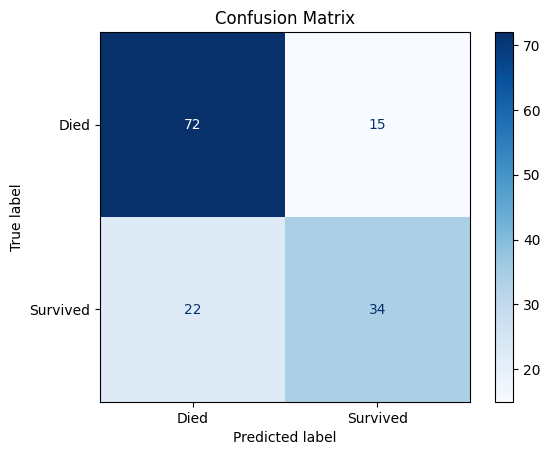

In [40]:
# Predict
y_pred = clf.predict(X_test)

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Died', 'Survived'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


### 4. From Scratch: Information Gain

In [41]:
# helper functions for entropy and information gain
def entropy(y):
    # y is a list/array of class labels
    classes, counts = np.unique(y, return_counts=True)
    probs = counts / counts.sum()
    return -np.sum(probs * np.log2(probs))

def info_gain(y, x):
    # y = target, x = feature to split on
    overall_entropy = entropy(y)
    values, counts = np.unique(x, return_counts=True)
    weighted_entropy = np.sum([(counts[i] / np.sum(counts)) * entropy(y[x == values[i]]) 
                               for i in range(len(values))])
    return overall_entropy - weighted_entropy


In [42]:
# Compute information gain for 'sex' and 'pclass'
ig_sex = info_gain(df['survived'], df['sex'])
ig_pclass = info_gain(df['survived'], df['pclass'])

print(f"Information Gain for 'sex': {ig_sex:.4f}")
print(f"Information Gain for 'pclass': {ig_pclass:.4f}")


Information Gain for 'sex': 0.2160
Information Gain for 'pclass': 0.0957


### 5. Visualization - Survival by Class and Gender

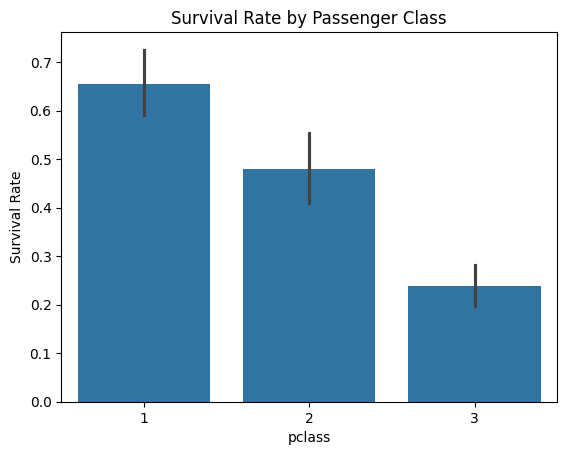

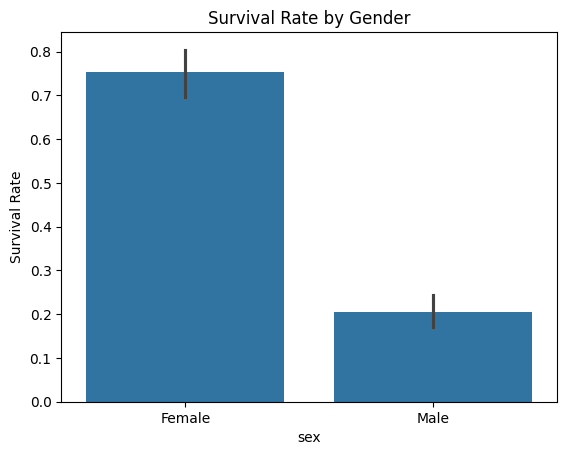

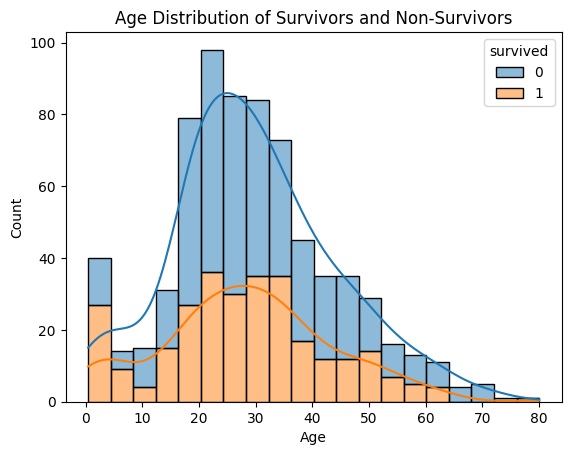

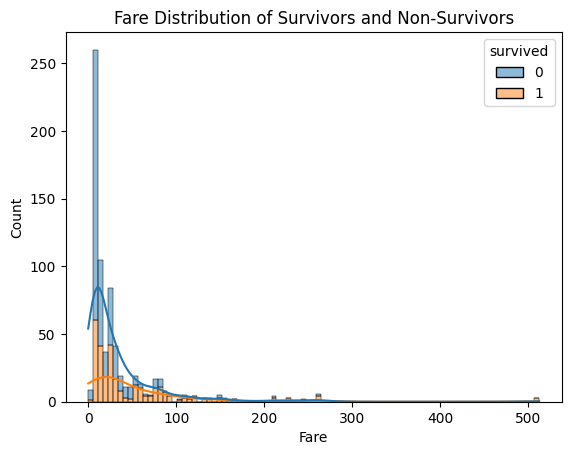

In [43]:
# Survival rate by Pclass
sns.barplot(data=df, x='pclass', y='survived')
plt.title("Survival Rate by Passenger Class")
plt.ylabel("Survival Rate")
plt.show()

# Survival rate by Gender
sns.barplot(data=df, x='sex', y='survived')
plt.title("Survival Rate by Gender")
plt.ylabel("Survival Rate")
plt.xticks([0, 1], ['Female', 'Male'])
plt.show()
# Age distribution of survivors and non-survivors
sns.histplot(data=df, x='age', hue='survived', multiple='stack', kde=True)
plt.title("Age Distribution of Survivors and Non-Survivors")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()
# Fare distribution of survivors and non-survivors
sns.histplot(data=df, x='fare', hue='survived', multiple='stack', kde=True)
plt.title("Fare Distribution of Survivors and Non-Survivors")
plt.xlabel("Fare")
plt.ylabel("Count")
plt.show()

### 6. Performance Analysis Discussion

- **About the Splits:**  
  The decision tree first splits the data based on **sex** because it provides the most useful information about who survived. This fits with what we know historically—that women and children were more likely to be rescued.

- **Precision and Recall:**  
  - Recall for "Died" (the class of passengers who died):
    - This tells you how many of the actual "Died" passengers the model correctly identified.
    - High recall for "Died" means the model finds most of the passengers who didn’t survive.
    - The model is better at correctly identifying passengers who **did not survive** (higher recall for the "Died" group).  
  
  - Precision for "Survived" (the class of passengers who survived):
    - This tells you, when the model predicts "Survived," how often it is correct.
    - High precision for "Survived" means the model rarely mistakes someone who actually died as a survivor.
    - When it predicts someone **survived**, it is usually correct (higher precision for the "Survived" group).

- **Possible Bias:**  
  The model mainly depends on features like **gender** and **passenger class**, which strongly influence survival. This means it might overlook some unusual cases or less obvious patterns.
